<a href="https://colab.research.google.com/github/WellFan/bayesian_with_merchants/blob/main/merchants_goods_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import stats
import stan
import arviz as az
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

Consider the following model:

$\mu_i\sim Beta(\alpha_u, \beta_u)\\
trial_i\sim Gamma(10,10)$


With parameter tranformation:

$\alpha_i=\mu_i*trial_i\\
\beta_i=(1-\mu_i)*trial_i$

The relation between datas and parameters:

$ctr_{ij}\sim Beta(\alpha_i, \beta_i)\\
click_{ij}\sim Bin(impression_{ij}, ctr_{ij})$

Let i denote the i'th merchant, let (i,j) denote the j'th kind of goods from i'th merchant

---

In [2]:
nmerchants = 100
ngoods = np.random.randint(low=1, high=101, size=nmerchants)
alpha_u = 2
beta_u = 98
mu_i = stats.beta.rvs(alpha_u, beta_u, size=nmerchants)
trial = stats.gamma.rvs(10, scale=10, size=nmerchants)
true_parameters = {'alpha_u':alpha_u, 'beta_u':beta_u, 'mu_i':mu_i, 'trial':trial, 'ngoods':ngoods, 'alpha_i':mu_i*trial, 'beta_i':(1-mu_i)*trial}
data = np.array(([0], [0], [0], [0]))
for i in range(nmerchants):
  ctr = np.array(stats.beta.rvs(mu_i[i]*trial[i], (1-mu_i[i])*trial[i], size=ngoods[i]))
  impression = np.random.randint(low=1, high=101, size=ngoods[i])
  click = np.array(stats.binom.rvs(impression, ctr))
  merchants_id = np.array([i]*ngoods[i])
  temp = (np.vstack((merchants_id, ctr, impression, click)))
  data = np.hstack((data, temp))
data = np.transpose(data)
data = np.delete(data, 0, 0)

In [3]:
data = np.delete(data, 0, 0)
data.shape

(4998, 4)

In [4]:
text='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  vector<lower=0>[M] trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
  real<lower=0> alpha_trial;
  real<lower=0> beta_trial; 
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu.*trial;
  beta_i = (1-mu).*trial; 
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(alpha_trial, beta_trial);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df = fit.to_frame()

Building...



Building: 57.3s, done.Messages from stanc:
Warning in '/tmp/httpstan_zl3nkh9i/model_df4ao762.stan', line 25, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_zl3nkh9i/model_df4ao762.stan', line 25, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_zl3nkh9i/model_df4ao762.stan', line 25, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [5]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-24499.790094,0.937789,0.103803,4.0,23.0,1.0,24614.870159,0.021423,0.024910,0.010571,...,1.368289,219.515756,115.616122,18.372514,31.613814,59.713654,72.681092,61.848099,395.291988,132.902923
1,-24498.324448,0.927178,0.103803,5.0,31.0,0.0,24597.349202,0.024946,0.014578,0.012048,...,3.521057,80.385468,32.497060,24.589756,59.206978,21.834292,74.381414,296.421670,71.131342,96.892219
2,-24498.011141,0.999509,0.103803,5.0,31.0,0.0,24585.014968,0.024377,0.035393,0.016429,...,1.552593,195.904336,420.631565,16.076663,26.780029,55.461904,62.273215,22.561113,278.900022,111.374257
3,-24499.000098,0.884683,0.103803,4.0,27.0,1.0,24602.304736,0.019927,0.017994,0.013296,...,2.210040,90.401000,182.460672,17.628687,34.685379,31.730337,103.807766,32.053722,470.964581,77.682687
4,-24513.157515,0.907320,0.103803,5.0,31.0,0.0,24615.586853,0.018618,0.018930,0.013708,...,3.528790,351.382195,127.014878,17.364223,39.184037,34.640056,83.203044,127.133929,117.327333,62.036386


---

After the estimation, Stan brings lots of draws of $\hat{\alpha_u},\hat{\beta_u},\hat{\mu_i},\hat{trial_i}$

And from sample distribution

$\hat{\alpha_u}\stackrel{p}{\to}\alpha_u\\
\hat{\beta_u}\stackrel{p}{\to}\beta_u\\
\bar{\hat{\mu_i}}\stackrel{p}{\to}\mu_i\sim Beta(\alpha_\mu, \beta_\mu)\\
\bar{\hat{trial_i}}\stackrel{p}{\to}trial_i\sim Gamma(10, 10)$

---

In [6]:
df.iloc[:,209:211].mean()

parameters
alpha_trial    1.705535
beta_trial     0.015056
dtype: float64

In [7]:
alpha_u = df['alpha_u']
beta_u = df['beta_u']
alpha_trial = df['alpha_trial']
beta_trial = df['beta_trial']
mu = df.iloc[:,7:107]
trial = df.iloc[:,107:207]
alpha_i = df.iloc[:, 211:311]
beta_i = df.iloc[:, 311:411]

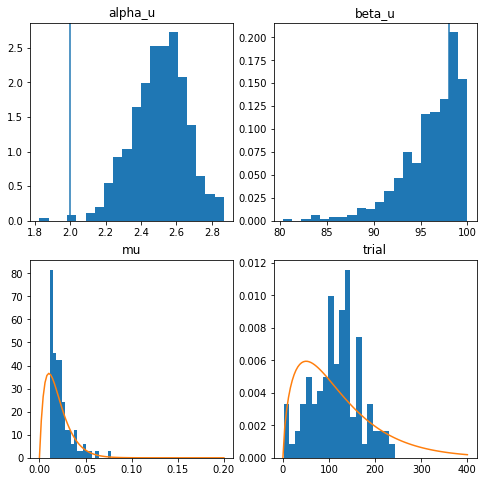

In [8]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].set_title('alpha_u')
axes[0,0].hist(alpha_u, density=True, bins=20)
axes[0,0].axvline(true_parameters['alpha_u'])
axes[0,1].set_title('beta_u')
axes[0,1].hist(beta_u, density=True, bins=20)
axes[0,1].axvline(true_parameters['beta_u'])
axes[1,0].set_title('mu')
axes[1,0].hist(mu.mean(), density=True, bins=20)
axes[1,0].plot(np.linspace(0, 0.2, 100), stats.beta.pdf(np.linspace(0, 0.2, 100), 2, 98))
axes[1,1].set_title('trial')
axes[1,1].hist(trial.mean(), density=True, bins=20)
axes[1,1].plot(np.linspace(0, 400, 100), stats.gamma.pdf(np.linspace(0, 400, 100), a=alpha_trial.mean(), scale=(1/beta_trial).mean()))

In [9]:
customer_stan = pd.DataFrame(data, columns=['merchant_id', 'ctr', 'impression', 'click'])
customer_stan = customer_stan.astype({'merchant_id':int, 'impression':int, 'click':int})
customer_stan.head()

,merchant_id,ctr,impression,click
0,0,0.041723,41,1
1,0,0.035387,13,0
2,0,0.033533,20,0
3,0,0.013038,10,0
4,0,0.011996,42,0


In [10]:
customer_stan['alpha_i'] = alpha_i.mean()[customer_stan.merchant_id][1]
customer_stan['beta_i'] = beta_i.mean()[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_stan = lambda df:(df.click+df.alpha_i)/(df.impression+df.alpha_i+df.beta_i))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan
0,0,0.041723,41,1,2.794643,114.561871,0.023963
1,0,0.035387,13,0,2.794643,114.561871,0.021438
2,0,0.033533,20,0,2.794643,114.561871,0.020346
3,0,0.013038,10,0,2.794643,114.561871,0.021943
4,0,0.011996,42,0,2.794643,114.561871,0.017537


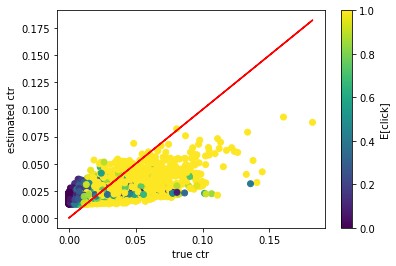

In [11]:
plt.scatter(customer_stan.ctr, customer_stan.avg_stan, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('estimated ctr')
plt.colorbar(label='E[click]')
plt.show()

In [12]:
customer_stan.ctr.corr(customer_stan.avg_stan)

0.6829814678782637

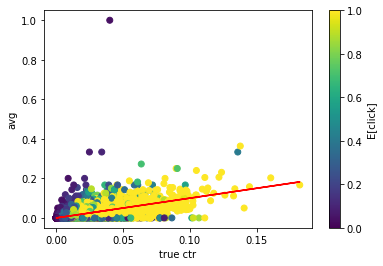

In [13]:
plt.scatter(customer_stan.ctr, customer_stan.click/customer_stan.impression, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('avg')
plt.colorbar(label='E[click]')
plt.show()

In [14]:
print('MSE of estimated ctr per goods', np.square(customer_stan.ctr-customer_stan.avg_stan).mean())
print('MSE of average ctr per goods', np.square(customer_stan.ctr-(customer_stan.click/customer_stan.impression)).mean())

MSE of estimated ctr per goods 0.00027017557363180367
MSE of average ctr per goods 0.000818274298470317


In [15]:
impression_per_merchants  = customer_stan.groupby(['merchant_id']).agg({'impression':sum, 'click':sum})['impression']
click_per_merchants  = customer_stan.groupby(['merchant_id']).agg({'impression':sum, 'click':sum})['click']

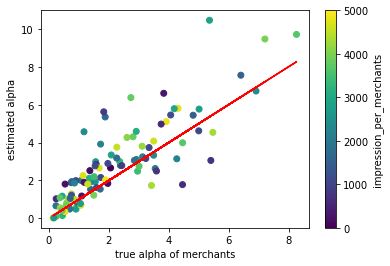

In [16]:
plt.scatter(true_parameters['alpha_i'], alpha_i.mean(),c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['alpha_i'], true_parameters['alpha_i'], color='red')
plt.xlabel('true alpha of merchants')
plt.ylabel('estimated alpha')
plt.colorbar(label='impression_per_merchants')
plt.show()

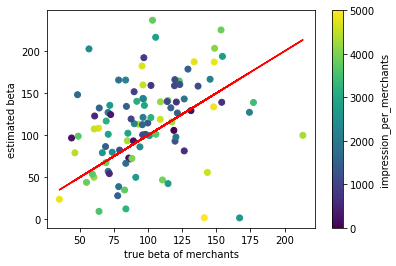

In [17]:
plt.scatter(true_parameters['beta_i'], beta_i.mean(), c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['beta_i'], true_parameters['beta_i'], color='red')
plt.xlabel('true beta of merchants')
plt.ylabel('estimated beta')
plt.colorbar(label='impression_per_merchants')
plt.show()

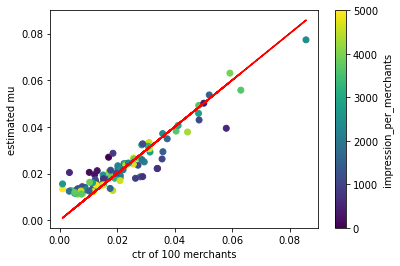

In [18]:
plt.scatter(true_parameters['mu_i'], mu.mean(), c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['mu_i'], true_parameters['mu_i'], color='red')
plt.xlabel('ctr of 100 merchants')
plt.ylabel('estimated mu')
plt.colorbar(label='impression_per_merchants')
plt.show()

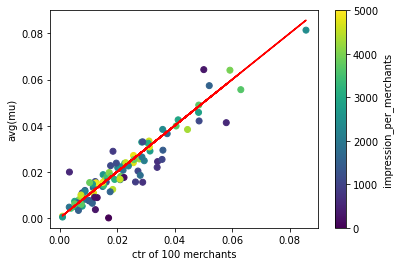

In [19]:
plt.scatter(true_parameters['mu_i'], click_per_merchants/impression_per_merchants, c=impression_per_merchants, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['mu_i'], true_parameters['mu_i'], color='red')
plt.xlabel('ctr of 100 merchants')
plt.ylabel('avg(mu)')
plt.colorbar(label='impression_per_merchants')
plt.show()

In [20]:
print('MSE of estimated ctr per merchants', np.square(true_parameters['mu_i']-mu.mean()).mean())
print('MSE of average ctr per merchants', np.square(true_parameters['mu_i']-click_per_merchants/impression_per_merchants).mean())

MSE of estimated ctr per merchants 3.366862673862322e-05
MSE of average ctr per merchants 2.7986983809138087e-05


---

Figure 1&2 compares tradional way to compute the ctr with the bayesian way.
The bayesian does better esimate the ctr when the expectation is low.
Intuitively, the prior that baysian gives makes a better fit when our observations is rather low.
Hence we have a default belief about how the good is when we see a new kind.

---

If we neglect the difference between merchants:

$ctr_i\sim Betabinomial(impression_i, \alpha,\beta)$

---

In [21]:
text2='''
data{
  int<lower=0> N;
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  real<lower=0> alpha;
  real<lower=0> beta;
}
model{
  alpha~uniform(0.01, 100);
  beta~uniform(0.01, 100);
  click~beta_binomial(impression, alpha, beta);
}
'''
stan_data = {'N':data.shape[0], 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text2, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_nomerchant = fit.to_frame()

Building...



Building: 38.1s, done.Messages from stanc:
Warning in '/tmp/httpstan_o1iirjcc/model_mrjqfvrf.stan', line 13, column 21: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_o1iirjcc/model_mrjqfvrf.stan', line 13, column 15: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_o1iirjcc/model_mrjqfvrf.stan', line 13, column 2: Parameter beta is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; fo

In [22]:
df_nomerchant.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta
draws,,,,,,,,,
0,-24852.819099,0.940170,0.263474,1.0,3.0,0.0,24854.132542,1.051325,49.683083
1,-24852.832224,0.952001,0.263474,3.0,15.0,0.0,24855.041614,0.935737,43.386043
2,-24853.176781,0.834915,0.263474,2.0,5.0,0.0,24854.561334,0.960555,43.981045
3,-24854.895328,0.986039,0.263474,3.0,11.0,0.0,24855.694616,1.092334,50.385191
4,-24852.968543,1.000000,0.263474,2.0,7.0,0.0,24855.712774,1.033961,49.962088


In [23]:
alpha_true = df_nomerchant.alpha.mean()
beta_true = df_nomerchant.beta.mean()
customer_stan = customer_stan.assign(avg_bayesian = lambda df:(df.click+alpha_true)/(df.impression+alpha_true+beta_true))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian
0,0,0.041723,41,1,2.794643,114.561871,0.023963,0.022423
1,0,0.035387,13,0,2.794643,114.561871,0.021438,0.016267
2,0,0.033533,20,0,2.794643,114.561871,0.020346,0.014579
3,0,0.013038,10,0,2.794643,114.561871,0.021943,0.017116
4,0,0.011996,42,0,2.794643,114.561871,0.017537,0.010993


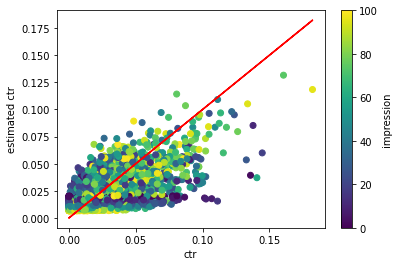

In [24]:
plt.scatter(customer_stan.ctr, customer_stan.avg_bayesian, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.xlabel('ctr')
plt.ylabel('estimated ctr')
plt.show()

---

Consider another model where merchants difference exists but with same trial, which is called beta-binomial regression.

$\mu_i\sim Beta(\alpha_u, \beta_u)\\
trial_i = c,\ ∀i$

With parameter tranformation: $\alpha_i=\mu_i*c,\ \beta_i=(1-\mu_i)*c$

The relation between datas and parameters:

$ctr_{ij}\sim Beta(\alpha_i, \beta_i)\\
click_{ij}\sim Bin(impression_{ij}, ctr_{ij})$

---

In [25]:
text3='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  real<lower=0> trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu*trial;
  beta_i = (1-mu)*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 0.1);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text3, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_same_trial = fit.to_frame()

Building...



Building: 41.0s, done.Messages from stanc:
Warning in '/tmp/httpstan_vy1sv7i9/model_uwba3zav.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_vy1sv7i9/model_uwba3zav.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_vy1sv7i9/model_uwba3zav.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [26]:
df_same_trial.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-24450.445204,0.998114,0.021529,7.0,127.0,0.0,24495.214094,0.024793,0.022999,0.010587,...,80.024007,79.059331,79.734216,80.034397,79.856337,80.103706,80.098140,79.849142,79.711117,77.842966
1,-24461.765754,0.991485,0.021529,6.0,118.0,1.0,24522.071747,0.025570,0.026939,0.010136,...,79.801226,78.953793,79.302578,79.675206,79.274871,79.798133,79.555874,79.465322,79.308150,77.838762
2,-24435.886463,1.000000,0.021529,7.0,127.0,0.0,24508.389132,0.026880,0.024974,0.010696,...,85.063138,83.606416,84.123273,84.834495,84.941309,85.034037,85.041791,84.961942,84.151673,82.929147
3,-24433.351208,0.987498,0.021529,6.0,87.0,1.0,24492.452779,0.019066,0.020236,0.010305,...,84.227956,82.122686,83.263897,84.015701,84.095793,84.221811,84.190057,84.032142,83.739361,81.470248
4,-24431.556915,0.963924,0.021529,4.0,28.0,1.0,24482.467034,0.019829,0.020406,0.010289,...,83.781264,81.700125,82.719635,83.511638,83.679377,83.774461,83.740652,83.578502,83.300577,81.044591


In [27]:
mu2 = df_same_trial.iloc[:,7:107].mean()
alpha_proun = df_same_trial.iloc[:,107].mean()*mu2
beta_proun = df_same_trial.iloc[:,107].mean()-alpha_proun

In [28]:
customer_stan['alpha_proun'] = alpha_proun[customer_stan.merchant_id][1]
customer_stan['beta_proun'] = beta_proun[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_uni_trial = lambda df:(df.click+df.alpha_proun)/(df.impression+df.alpha_proun+df.beta_proun))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian,alpha_proun,beta_proun,avg_uni_trial
0,0,0.041723,41,1,2.794643,114.561871,0.023963,0.022423,1.763553,78.449214,0.022799
1,0,0.035387,13,0,2.794643,114.561871,0.021438,0.016267,1.763553,78.449214,0.018920
2,0,0.033533,20,0,2.794643,114.561871,0.020346,0.014579,1.763553,78.449214,0.017598
3,0,0.013038,10,0,2.794643,114.561871,0.021943,0.017116,1.763553,78.449214,0.019549
4,0,0.011996,42,0,2.794643,114.561871,0.017537,0.010993,1.763553,78.449214,0.014430


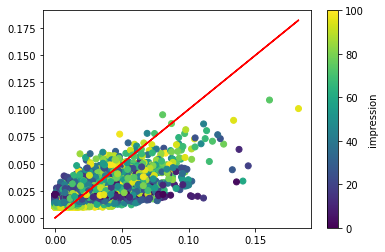

In [29]:
plt.scatter(customer_stan.ctr, customer_stan.avg_uni_trial, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.show()